In [1]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from ase.io import read
import abtem
import hyperspy.api as hs

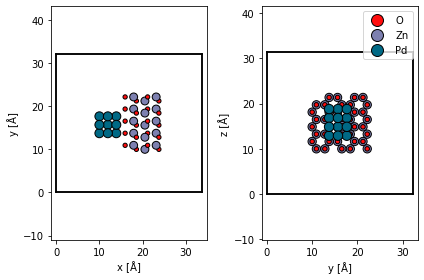

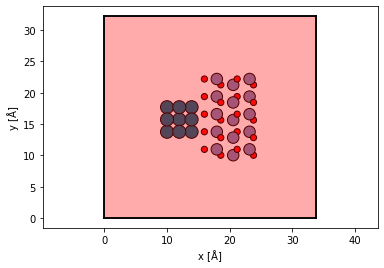

In [2]:
atoms = read(r"C:\Users\Joshu\Documents\Python Scripts\Catalyst Models\Clusters for simulation\Zno_tomography.cfg")
atoms.center(vacuum=10)

frozen_phonons=abtem.FrozenPhonons(atoms, 10, sigmas=0.2)
potential=abtem.Potential(frozen_phonons, gpts=(512, 512), slice_thickness=2)
s_matrix=abtem.SMatrix(potential=potential, energy=150e3, semiangle_cutoff=20, interpolation=4)
Cs=1e-6 * 1e10
ctf = abtem.CTF(Cs=Cs, defocus=0, energy=s_matrix.energy)

fig, (ax1, ax2) = plt.subplots(1, 2)
abtem.show_atoms(atoms, ax=ax1)
abtem.show_atoms(atoms, legend=True, ax=ax2, plane="yz")
plt.tight_layout()

sampling = abtem.transfer.nyquist_sampling(s_matrix.semiangle_cutoff, s_matrix.energy)

scan = abtem.GridScan(
    start=(0, 0),
    end=(1, 1),
    fractional=True,
    potential=potential,
    sampling=sampling,
)

fig, ax = abtem.show_atoms(atoms)
scan.add_to_plot(ax)

detector= abtem.AnnularDetector(inner=20, outer=100)
measurement = s_matrix.scan(scan=scan, detectors=detector,ctf=ctf).compute()

#flexible_measurement = s_matrix.scan(detectors=detector, ctf=ctf)
#flexible_measurement.compute()
#haadf_measurement=flexible_measurement.integrate_radial(20,100)
output = measurement.gaussian_filter(0.35).poisson_noise(dose_per_area=1e5)

measurement.show()
output.to_tiff('testing.tiff')

In [10]:
for theta in range(0,90,45):
    for phi in range(0, 90, 45):
        atoms_copy=atoms.copy()
        atoms_copy.euler_rotate(theta,phi)
        atoms_copy.center(vacuum=10)
        
        frozen_phonons=abtem.FrozenPhonons(atoms_copy, 10, sigmas=0.2)
        potential=abtem.Potential(frozen_phonons, gpts=1024, slice_thickness=2)
        s_matrix=abtem.SMatrix(potential=potential, energy=150e3, semiangle_cutoff=20, interpolation=4)
        Cs=1e-6 * 1e10
        ctf = abtem.CTF(Cs=Cs, defocus=0, energy=s_matrix.energy)

        detector= abtem.AnnularDetector(inner=20, outer=100)
        measurement = s_matrix.scan(scan=scan, detectors=detector,ctf=ctf).compute()
        output = measurement.gaussian_filter(0.35).poisson_noise(dose_per_area=1e5)
        output.to_tiff('atoms/atoms_cubo_phi' + str(phi) + '_theta' + str(theta) + '.tiff')
                                        
        
        #output.to_tiff('atoms/atoms_Cubo_phi'+str(phi)+'_theta'+theta+'.tiff')
        #output.to_tiff('atoms/atoms_Cubo_phi' + str(phi) + '_theta' + str(theta) + '.tiff')



#flexible_measurement = s_matrix.scan(detectors=detector, ctf=ctf)
#flexible_measurement.compute()
#haadf_measurement=flexible_measurement.integrate_radial(20,100)
#output = measurement.gaussian_filter(0.35).poisson_noise(dose_per_area=1e5)
        
#import os

#directory = 'C:\\Users\\Joshu\\Documents\\Python Scripts\\Ptychography\\atoms\\'
#if not os.path.exists(directory):
    #os.makedirs(directory)

# Save the file
#output.to_tiff(os.path.join(directory, 'atoms_Cubo_phi' + str(phi) + '_theta' + str(theta) + '.tiff'))

[########################################] | 100% Completed | 193.35 s
[########################################] | 100% Completed | 218.69 s
[########################################] | 100% Completed | 217.16 s
[########################################] | 100% Completed | 256.00 s


In [14]:
import os
from PIL import Image
import mrcfile

In [15]:
input_dir = 'C:/Users/Joshu/Documents/Python Scripts/General_TEM_simulation/atoms'
output_dir = 'C:/Users/Joshu/Documents/Python Scripts/General_TEM_simulation/atoms/MRC'
output_mrc_filename = 'stacked_volume.mrc'

In [16]:
tiff_files = [f for f in sorted(os.listdir(input_dir)) if f.endswith('.tiff')]

if not tiff_files:
    raise ValueError('No TIFF files found in the input directory.')

first_image = Image.open(os.path.join(input_dir, tiff_files[0]))
first_array = np.array(first_image)
height, width = first_array.shape[:2]

volume = np.zeros((len(tiff_files), height, width), dtype=np.float32)

for i, tiff_file in enumerate(tiff_files):
    tiff_path = os.path.join(input_dir, tiff_file)
    image = Image.open(tiff_path)
    volume[i] = np.array(image)

mrc_path = os.path.join(output_dir, output_mrc_filename)
with mrcfile.new(mrc_path, overwrite=True) as mrc:
    mrc.set_data(volume)

print(f'Stacked volume saved as MRC file: {mrc_path}')

Stacked volume saved as MRC file: C:/Users/Joshu/Documents/Python Scripts/General_TEM_simulation/atoms/MRC\stacked_volume.mrc
